In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !pip install gym[box2d]

    !touch .setup_complete

     |████████████████████████████████| 450kB 7.6MB/s 


In [ ]:
import random
import numpy as np
import torch
import CartPoleEnv

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
case = 2

def make_env(seed=None):
    # some envs are wrapped with a time limit wrapper by default
    env = CartPoleEnv.CartPoleEnv(6)
    if seed is not None:
        env.seed(seed)
    return env

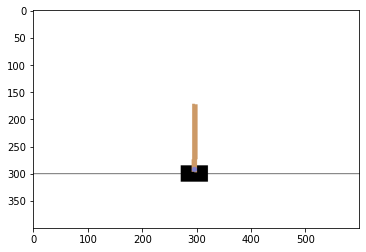

In [ ]:
env = make_env()
env.reset()
plt.imshow(env.render("rgb_array"))
state_shape, n_actions = env.observation_space.shape, env.action_space.n

In [ ]:
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='cpu')

In [ ]:
from tqdm import trange
from IPython.display import clear_output

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [ ]:
env = make_env(seed)
state_dim = env.observation_space.shape
n_actions = env.action_space.n
state = env.reset()

**A2C**

In [ ]:
#based on https://raw.githubusercontent.com/pytorch/examples/master/reinforcement_learning/actor_critic.py
#Parameters of the model are saved in 'model_a2c'

import gym
import numpy as np
from itertools import count
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import CartPoleEnv
import importlib

importlib.reload(CartPoleEnv)

env = make_env()
gamma = 0.9
log_interval = 200
reward_threshold = 200

SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])


class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(4, 64)
        self.affine2 = nn.Linear(64, 128)

        # actor's layer
        self.action_head = nn.Linear(128, 2)

        # critic's layer
        self.value_head = nn.Linear(128, 1)

        # action & reward buffer
        self.saved_actions = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        x = F.relu(self.affine2(x))

        # actor: choses action to take from state s_t 
        # by returning probability of each action
        action_prob = F.softmax(self.action_head(x), dim=-1)

        # critic: evaluates being in the state s_t
        state_values = self.value_head(x)

        # return values for both actor and critic as a tuple of 2 values:
        # 1. a list with the probability of each action over the action space
        # 2. the value from state s_t 
        return action_prob, state_values


model = Policy()
optimizer = optim.Adam(model.parameters(), lr=3e-2)
eps = np.finfo(np.float32).eps.item()


def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = model(state)

    # create a categorical distribution over the list of probabilities of actions
    m = Categorical(probs)

    # and sample an action using the distribution
    action = m.sample()

    # save to action buffer
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value))

    # the action to take (left or right)
    return action.item()


def finish_episode():
    R = 0
    saved_actions = model.saved_actions
    policy_losses = [] # list to save actor (policy) loss
    value_losses = [] # list to save critic (value) loss
    returns = [] # list to save the true values

    # calculate the true value using rewards returned from the environment
    for r in model.rewards[::-1]:
        # calculate the discounted value
        R = r + gamma * R
        returns.insert(0, R)

    returns = torch.tensor(returns, dtype=torch.float32)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()

        # calculate actor (policy) loss 
        policy_losses.append(-log_prob * advantage)

        # calculate critic (value) loss using L1 smooth loss
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R], dtype=torch.float32)))

    # reset gradients
    optimizer.zero_grad()

    # sum up all the values of policy_losses and value_losses
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    # perform backprop
    loss.backward()
    optimizer.step()

    # reset rewards and action buffer
    del model.rewards[:]
    del model.saved_actions[:]


def a2c():
    running_reward = 10

    # run inifinitely many episodes
    for i_episode in range(5000):

        # reset environment and episode reward
        state = env.reset()
        ep_reward = 0

        # for each episode, only run 9999 steps so that we don't 
        # infinite loop while learning
        for t in range(1, 10000):

            # select action from policy
            action = select_action(state)

            # take the action
            state, reward, done, _ = env.step(action)

            model.rewards.append(reward)
            ep_reward += reward
            if done:
                break

        # update cumulative reward
        running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward

        # perform backprop
        finish_episode()

        # log results
        if i_episode % log_interval == 0:
            print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}'.format(
                  i_episode, ep_reward, running_reward))
        
        if running_reward > 190:
            break


        # check if we have "solved" the cart pole problem

In [ ]:
def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = model(state)

    m = Categorical(probs)
    action = m.sample()

    return action.item()

In [ ]:
a2c()

Episode 0	Last reward: 130.00	Average reward: 16.00
Episode 200	Last reward: 201.00	Average reward: 153.83


**REINFORCE**

In [ ]:
# torch.save(model, 'model_a2c')

model = torch.load('model_a2c')
model.eval()

Policy(
  (affine1): Linear(in_features=4, out_features=64, bias=True)
  (affine2): Linear(in_features=64, out_features=128, bias=True)
  (action_head): Linear(in_features=128, out_features=2, bias=True)
  (value_head): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
def MonteCarloEval(s0, alg_type, n_samples=10, gamma = 0.99):
    env = make_env()
    average_reward = 0.
    total_states = []
    for k in range(n_samples):
        discounted_reward = 0.
        s = env.reset(s0)
        # s = env.reset()
        cur_gamma = 1.
        while True:
            a = None
            if alg_type == 'a2c':
                a = select_action(np.array([s]))
            elif alg_type == 'LD':
                a = env.getBestAction(s)
            elif alg_type == 'random':
                a = np.random.choice(range(2))
            new_s, r, done, _ = env.step(a)
            discounted_reward += cur_gamma * r
            total_states.append(s)
            s = new_s
            cur_gamma *= gamma
            if done:
                break

        average_reward += discounted_reward

    return average_reward / n_samples

In [ ]:
def SampleTrajectory(alg_type, n_samples=15):
    traj = []
    traj_values = []
    s = env.reset()
    iter = 0
    while True:
        traj.append(s)
        traj_values.append(MonteCarloEval(s, alg_type, n_samples, gamma=0.9))
        a = None
        if alg_type == 'a2c':
            a = select_action(np.array([s]))
        elif alg_type == 'LD':
            a = env.getBestAction(s)
        elif alg_type == 'random':
            a = np.random.choice(range(2))
        new_s, r, done, _ = env.step(a)
        s = new_s
        if done:
            break

    return torch.FloatTensor(np.vstack(traj)), torch.FloatTensor(np.vstack(traj_values))

In [ ]:
from tqdm import tqdm_notebook

def SampleSupportPoints(alg_type, n_traj, t_max):
    trajectories = []
    env = make_env()
    for i in tqdm_notebook(range(n_traj)):
        s = env.reset()
        states = [s]
        while True:
            a = None
            if alg_type == 'a2c':
                a = select_action(np.array([s]))
            elif alg_type == 'LD':
                a = env.getBestAction(s)
            elif alg_type == 'random':
                a = np.random.choice(range(2))

            new_s, r, done, _ = env.step(a)
            if done:
                break
            states.append(list(s))
            s = new_s

        if len(states) >= t_max:
            trajectories.append(np.array(states))

    traj_t = []
    for traj in trajectories:
        traj_t.append(traj[t_max - 1])

    return traj_t

In [ ]:
import bounds
import importlib
import torch
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/numba/core/decorators.py:252: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


No handles with labels found to put in legend.


<Figure size 576x396 with 0 Axes>

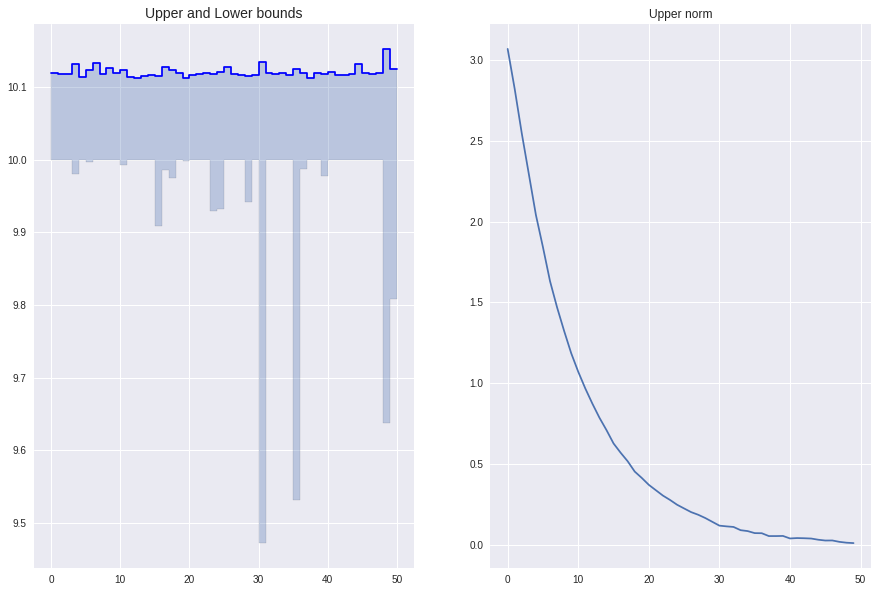

100%|██████████| 51/51 [37:01<00:00, 43.56s/it]


In [ ]:
alg_type = 'a2c'
env = make_env()
traj, traj_values = SampleTrajectory(alg_type, n_samples=30)
traj_t = SampleSupportPoints(alg_type, 2000, 50)
X_samples_pi, rewards_pi = bounds.generate_samples_given(env, traj_t)
V_pi2 = bounds.VpiEstimation(env, X_samples_pi, model, alg_type, 40, gamma=0.9)
V_up, V_pi, samples, upper_bound_sample = bounds.getMonteCarloUpperBounds(env, model, X_samples_pi, rewards_pi, V_pi2, gamma=0.9)

np.save('V_up_' + alg_type, V_up)
np.save('upper_bound_sample_' + alg_type, upper_bound_sample)
np.save('traj_' + alg_type, traj.numpy())
np.save('traj_values_' + alg_type, traj_values.numpy())
np.save('X_samples_pi_' + alg_type, X_samples_pi.numpy())
np.save('rewards_pi_' + alg_type, rewards_pi.numpy())
np.save('V_pi2_' + alg_type, V_pi2.numpy())

No handles with labels found to put in legend.


<Figure size 576x396 with 0 Axes>

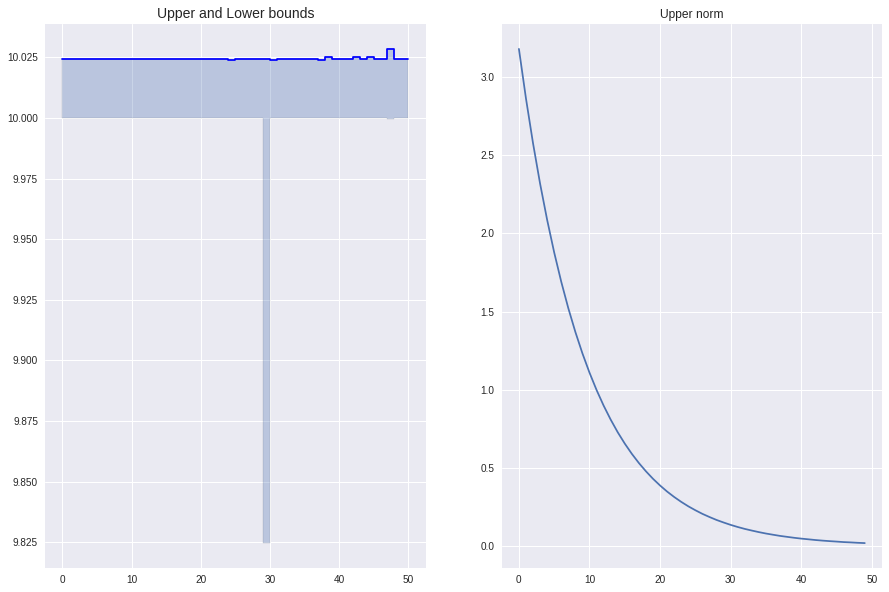

100%|██████████| 51/51 [44:20<00:00, 52.16s/it]


In [ ]:
alg_type = 'LD'
env = make_env()
traj, traj_values = SampleTrajectory(alg_type, n_samples=40)
traj_t = SampleSupportPoints(alg_type, 2000, 50)
X_samples_pi, rewards_pi = bounds.generate_samples_given(env, traj_t)
V_pi2 = bounds.VpiEstimation(env, X_samples_pi, model, alg_type, 40, gamma=0.9)
V_up, V_pi, samples, upper_bound_sample = bounds.getMonteCarloUpperBounds(env, model, X_samples_pi, rewards_pi, V_pi2, gamma=0.9)

np.save('V_up_' + alg_type, V_up)
np.save('upper_bound_sample_' + alg_type, upper_bound_sample)
np.save('traj_' + alg_type, traj.numpy())
np.save('traj_values_' + alg_type, traj_values.numpy())
np.save('X_samples_pi_' + alg_type, X_samples_pi.numpy())
np.save('rewards_pi_' + alg_type, rewards_pi.numpy())
np.save('V_pi2_' + alg_type, V_pi2.numpy())

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

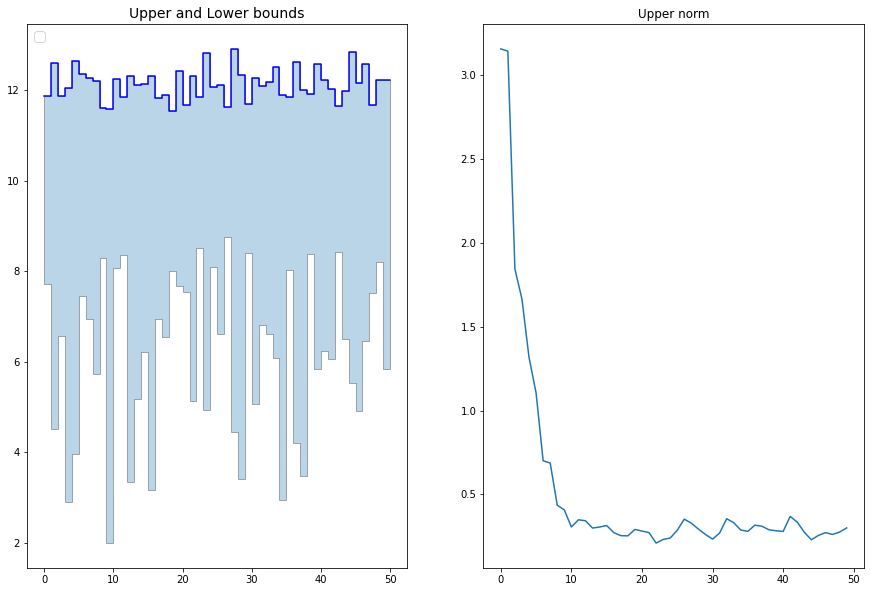

100%|██████████| 51/51 [44:54<00:00, 52.84s/it]


In [ ]:
alg_type = 'random'
env = make_env()
traj, traj_values = SampleTrajectory(alg_type, 40)
traj_t = SampleSupportPoints(alg_type, 4000, 20)
X_samples_pi, rewards_pi = bounds.generate_samples_given(env, traj_t)
V_pi2 = bounds.VpiEstimation(env, X_samples_pi, model, alg_type, 40, gamma=0.9)
V_up, V_pi, samples, upper_bound_sample = bounds.getMonteCarloUpperBounds(env, model, X_samples_pi, rewards_pi, V_pi2, gamma=0.9)

np.save('V_up_' + alg_type, V_up)
np.save('upper_bound_sample_' + alg_type, upper_bound_sample)
np.save('traj_' + alg_type, traj.numpy())
np.save('traj_values_' + alg_type, traj_values.numpy())
np.save('X_samples_pi_' + alg_type, X_samples_pi.numpy())
np.save('rewards_pi_' + alg_type, rewards_pi.numpy())
np.save('V_pi2_' + alg_type, V_pi2.numpy())

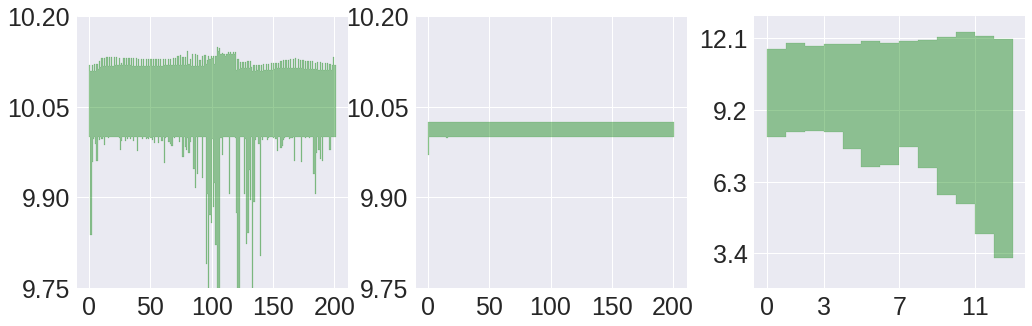

In [ ]:
V_up_a2c = torch.FloatTensor(np.load('V_up_a2c.npy'))
X_samples_pi_a2c = np.load('X_samples_pi_a2c.npy')
traj_a2c = torch.FloatTensor(np.load('traj_a2c.npy'))
traj_values_a2c = np.load('traj_values_a2c.npy')

V_up_determ = torch.FloatTensor(np.load('V_up_LD.npy'))
X_samples_pi_determ = np.load('X_samples_pi_LD.npy')
traj_determ = torch.FloatTensor(np.load('traj_LD.npy'))
traj_values_determ = np.load('traj_values_LD.npy')

V_up_random = torch.FloatTensor(np.load('V_up_random.npy'))
X_samples_pi_random = np.load('X_samples_pi_random.npy')
traj_random = torch.FloatTensor(np.load('traj_random.npy'))
traj_values_random = np.load('traj_values_random.npy')


# fig = plt.figure(figsize=(8, 21))
fig, ax = plt.subplots(1, 3, figsize=(17, 5))
params = {'major_ticksx': np.arange(0, 201, 50),
          'major_ticksy': np.arange(9.75, 10.201, 0.15),
          'y_lim': [9.75, 10.2],
          'tick_size': 25}
bounds.plotBounds(V_up_a2c, traj_values_a2c, X_samples_pi_a2c, traj_a2c, ax[0], params)
params = {'major_ticksx': np.arange(0, 201, 50),
          'major_ticksy': np.arange(9.75, 10.201, 0.15),
          'y_lim': [9.75, 10.2],
          'tick_size': 25}
bounds.plotBounds(V_up_determ, traj_values_determ, X_samples_pi_determ, traj_determ, ax[1], params)
params = {'major_ticksx': [0, 3, 7, 11],
          'major_ticksy': np.linspace(3.4, 12.1, 4),
          'y_lim': [2, 13],
          'tick_size': 25}
bounds.plotBounds(V_up_random, traj_values_random, X_samples_pi_random, traj_random, ax[2], params)

plt.subplots_adjust(wspace=0.25, hspace=0.2)
plt.grid(True)
# plt.tight_layout()
plt.savefig('graph_result.png')
plt.show()

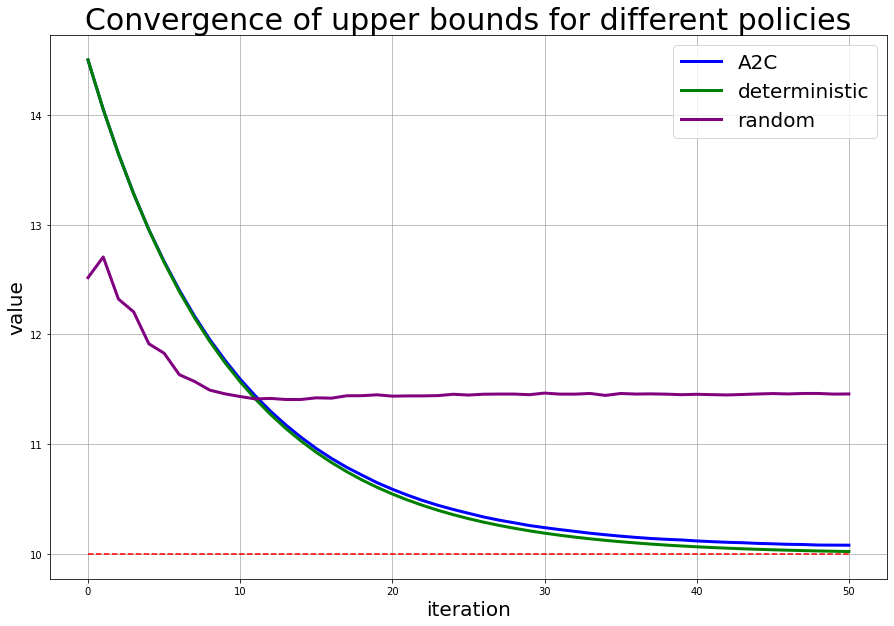

In [ ]:
upper_bound_sample_a2c = np.load('upper_bound_sample_a2c.npy')
upper_bound_sample_determ = np.load('upper_bound_sample_determ.npy')
upper_bound_sample_random = np.load('upper_bound_sample_random.npy')

plt.figure(figsize=(15, 10))
optimal = np.logspace(0, 200, num=201, base=0.9).sum()
plt.plot(np.full(51, optimal), 'r--')
plt.plot(upper_bound_sample_a2c, 'b', linewidth=3, label='A2C')
plt.plot(upper_bound_sample_determ, 'green', linewidth=3, label='deterministic')
plt.plot(upper_bound_sample_random, 'purple', linewidth=3, label='random')
plt.title("Convergence of upper bounds for different policies", fontsize=30)
plt.ylabel("value", fontsize=20)
plt.xlabel("iteration", fontsize=20)
plt.legend(fontsize=20)
plt.grid()
plt.savefig('graph_convergence.png')
plt.show()

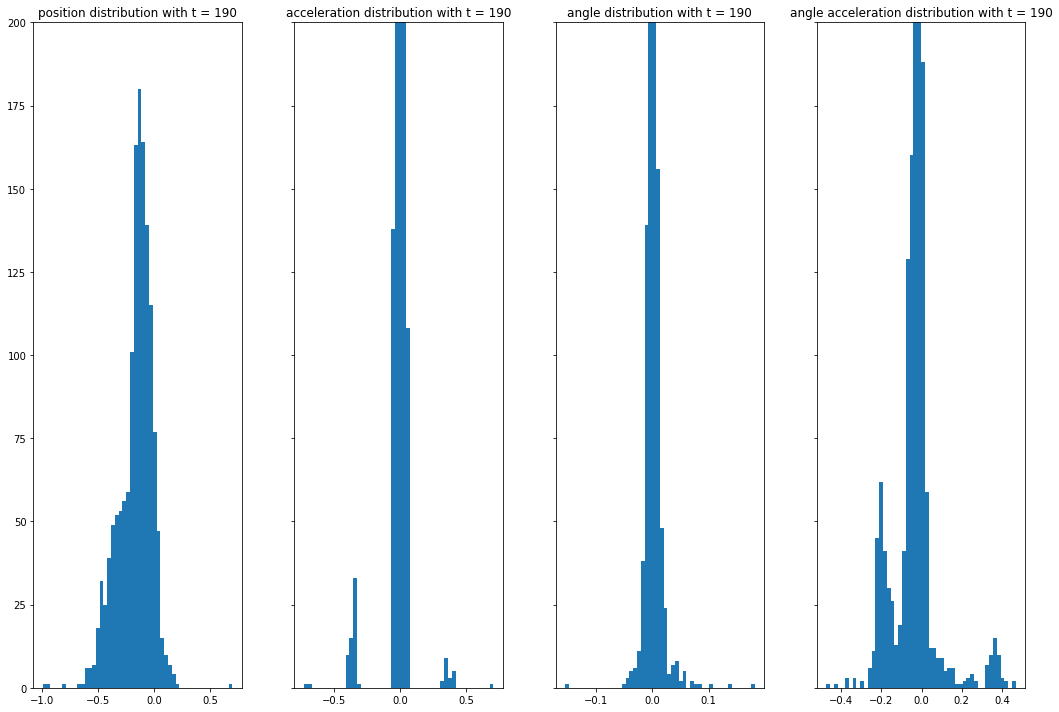

IndexError: ignored

In [ ]:
n_bins = 50
for t in range(0, t_max + 1, 10):
    traj_t = []
    for traj in trajectories:
        traj_t.append(traj[t])
    traj_t = np.vstack(traj_t)

    clear_output(True)
    fig, axs = plt.subplots(1, 4, sharey=True, tight_layout=True, figsize=(15, 10))

    axs[0].hist(traj_t[:, 0], bins=n_bins)
    axs[0].set_title("position distribution with t = " + str(t))
    axs[1].hist(traj_t[:, 1], bins=n_bins)
    axs[1].set_title("acceleration distribution with t = " + str(t))
    axs[2].hist(traj_t[:, 2], bins=n_bins)
    axs[2].set_title("angle distribution with t = " + str(t))
    axs[3].hist(traj_t[:, 3], bins=n_bins)
    axs[3].set_title("angle acceleration distribution with t = " + str(t))
    plt.ylim(0, 200)
    # plt.savefig('./fig_a2c/fig' + str(t))
    plt.show()
    plt.pause(1)

In [ ]:
import scipy

def BellmanEval(states, gamma=0.99):
    env = CartPoleEnv.CartPoleEnv()
    Yxa0 = []
    Yxa1 = []
    rewards0 = []
    rewards1 = []
    rv = scipy.stats.multivariate_normal(cov=np.diag([0.0004, 0.01, 0.0004, 0.01]))
    for i in range(states.shape[0]):
        env.reset(states[i].numpy())
        Yxk0, r0, _, _ = env.step(0, with_noise=False)
        env.reset(states[i].numpy())
        Yxk1, r1, _, _ = env.step(1, with_noise=False)
        Yxa0.append(Yxk0)
        Yxa1.append(Yxk1)
        rewards0.append(r0)
        rewards1.append(r1)

    Yxa0 = torch.tensor(Yxa0, device=device, dtype=torch.float32)
    Yxa1 = torch.tensor(Yxa1, device=device, dtype=torch.float32)
    rewards0 = torch.tensor(rewards0, device=device, dtype=torch.float32)
    rewards1 = torch.tensor(rewards1, device=device, dtype=torch.float32)
    Trewards = torch.cat((rewards0[None, :], rewards1[None, :]), axis=0)
    Txa = torch.cat((Yxa0[None, :, :], Yxa1[None, :, :]), axis=0)
    probs0 = []
    probs1 = []

    sub1 = X_samples_pi.numpy()[:, np.newaxis] - Txa.numpy()[0]
    sub2 = X_samples_pi.numpy()[:, np.newaxis] - Txa.numpy()[1]
    p1 = rv.pdf(sub1)
    p2 = rv.pdf(sub2)
    probs = torch.stack((torch.from_numpy(p1), torch.from_numpy(p2)))
    norm_probs = torch.nan_to_num(torch.div(probs, torch.sum(probs, keepdim=True, dim=1)))
    mean = torch.transpose(norm_probs, 1, 2) * V_pi2
    mean = torch.max(Trewards + gamma * mean.sum(dim=-1), dim=0)[0]

    return mean

In [ ]:
traj = []
s = env.reset()
while True:
    action_probs = predict_probs(np.array([s]))[0]
    a = np.random.choice(n_actions, p=action_probs)
    new_s, r, done, _ = env.step(a)
    traj.append(s.tolist())
    s = new_s
    if done:
        print(len(traj))
        break

201


In [ ]:
from tqdm import tnrange, tqdm_notebook

avg_rewards = []
for i in tqdm_notebook(range(len(traj))):
    state = traj[i]
    avg_reward = MonteCarloEval(state, alg_type='a2c', n_samples=20, gamma=0.9)
    avg_rewards.append(avg_reward)

traj = torch.tensor(traj, dtype=torch.float32)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [ ]:
bellman_rewards = BellmanEval(traj)

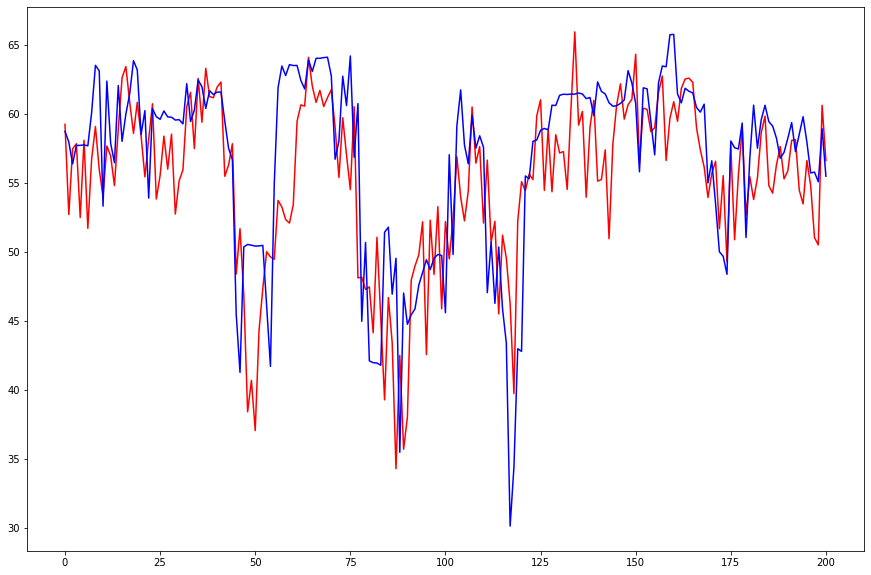

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(avg_rewards, 'r-')
plt.plot(bellman_rewards.numpy(), 'b-')

plt.show()

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import DistanceMetric
import sklearn

neigh = NearestNeighbors(n_neighbors=5, algorithm='kd_tree', leaf_size=30, n_jobs=-1)
neigh.fit(X_samples_pi.tolist())
_, idxes_neigh = neigh.kneighbors(traj.numpy().tolist())
V_pi_data = V_pi2[torch.tensor(idxes_neigh)].mean(dim=-1).numpy()

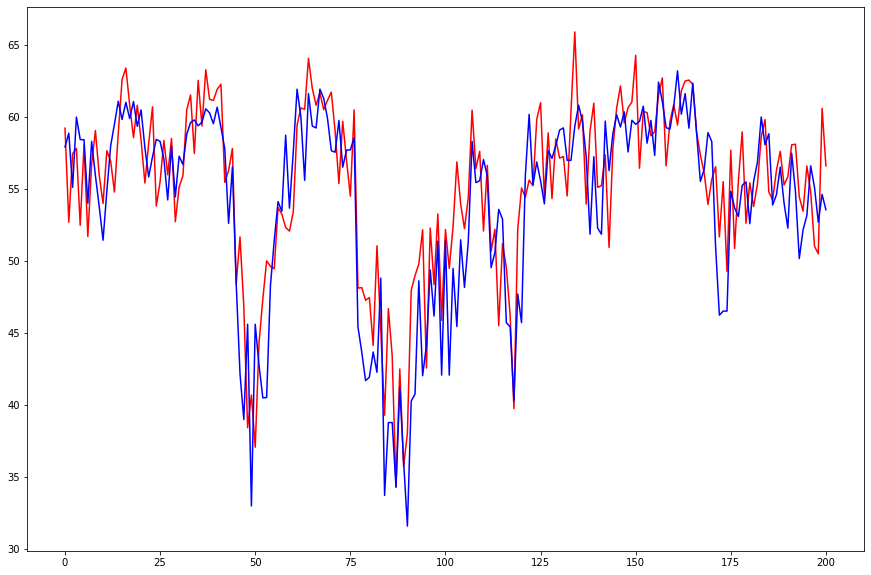

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(avg_rewards, 'r-')
plt.plot(V_pi_data, 'b-')

plt.show()